In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision 
from torchvision import datasets,transforms
import shutil

C:\Users\22789\Anaconda3\envs\pytorch_py\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = r'C:\Users\22789\Desktop\学校课程学习\路飞python\4weather'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

In [3]:
transform = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5])
]) 

In [4]:
train_ds = torchvision.datasets.ImageFolder(
        train_dir,
        transform = transform
)

In [5]:
test_ds = torchvision.datasets.ImageFolder(
        test_dir,
        transform = transform
)

In [6]:
batch = 32
# 1.使用dataloader封装训练数据和测试数据
train_dl = torch.utils.data.DataLoader(
    train_ds,batch_size = batch,shuffle= True
)
test_dl = torch.utils.data.DataLoader(
    test_ds,batch_size = batch
)

torchvision  1.预训练数据 2.预训练模型

In [7]:
model = torchvision.models.vgg16(pretrained=True)

In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
for p in model.features.parameters():
    p.requires_grad = False

In [10]:
model.classifier[-1].out_features = 4

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
optimizer = torch.optim.Adam(model.classifier.parameters(),lr=0.0001)

In [13]:
loss_fn = nn.CrossEntropyLoss()

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [22]:
if torch.cuda.is_available():
    model.to(device)

In [23]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                y_pred = torch.argmax(y_pred, dim=1)
                test_correct += (y_pred == y).sum().item()
                test_total += y.size(0)
                test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', (epoch+1), 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [24]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 20 
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc=fit(epoch,model,train_dl,test_dl)
    
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  1 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.956
epoch:  2 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.951
epoch:  3 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.947
epoch:  4 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.956
epoch:  5 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.956
epoch:  6 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.956
epoch:  7 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.956
epoch:  8 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.951
epoch:  9 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.956
epoch:  10 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.951
epoch:  11 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.951
epoch:  12 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.951
epoch:  13 loss：  0.0 accuracy: 1.0 test_loss：  0.008 test_accuracy: 0.951
epoch:  14 loss：  0.0 accuracy: 1.

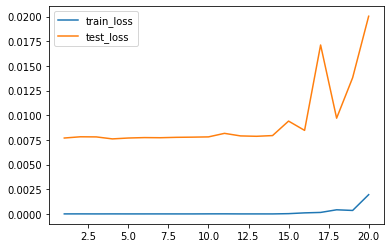

In [26]:
plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss')
plt.legend()

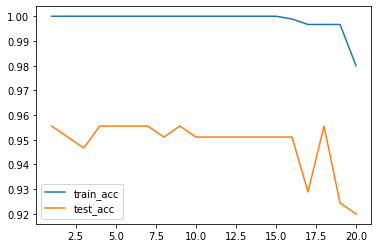

In [27]:
plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc')
plt.legend()